# 1. Load data from keras
train_data = 
[ 
  
　　[犯罪率, 高速公路可達性,... 等13個featurne]

　　..
　
  
　　404個

]

train_labels = 
[15.2, 17.8, ..] 

一人自住房屋的中位數，單位：千美元

In [1]:
from keras.datasets import boston_housing
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 2us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
train_labels.shape

(404,)

# 2.正規化，注意!!testing data必須使用training data計算的
# mean 與 std計算，不能使用任何來自testing data的資訊，否則會資訊洩漏!

In [4]:
# 對axis=0軸計算平均，係指將每個feature都計算所有樣本數加總後的平均
# 本例有13個feature，計算完之後的mean shape為(13,)
mean = train_data.mean(axis=0)

# (404, 13) - (13,), 這邊會array broadcasting變成(404, 13) - (404, 13) = (404, 13)
train_data -= mean

# std.shape = (13,)
std = train_data.std(axis=0)

# 同理，train_data.shape保持(404, 13)
train_data /= std

train_data.shape




(404, 13)

# 3. define/build mode
## 這邊的重點是使用mean squared error當作loss，且測量指標為mean absolute error當作驗證指標（預測值與目標值的絕對值差異）

In [0]:
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64,
                         activation='relu',
                         input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model



# 4. K-fold驗證
## 因為training data比較少，驗證時將training data分批，輪流當驗證集與訓練集，
## 驗證值的變異性。

In [6]:

import numpy as np

k = 4 # 4折
num_part = len(train_data) // k 
num_epochs=500

all_mae_histories = []
all_maes = []

for idx in range(k):
  print('processing fold #{}..'.format(idx))
  # x
  x_partial_pre = train_data[0 : idx * num_part]
  x_partial_after = train_data[ (idx+1) * num_part:]
  x_partial = np.concatenate([x_partial_pre, x_partial_after], axis=0)
  x_val = train_data[idx * num_part: (idx+1) * num_part]
  print('x_partial.shape = {}, x_val.shape = {}'.format(x_partial.shape, x_val.shape))

  # y
  y_partial_pre = train_labels[0 : idx*num_part]
  y_partial_after = train_labels[ (idx+1) * num_part:]
  y_partial = np.concatenate([y_partial_pre, y_partial_after], axis=0)
  y_val = train_labels[idx * num_part: (idx+1) * num_part]
  print('y_partial.shape = {}, y_val.shape = {}'.format(y_partial.shape, y_val.shape))

  model = build_model()
  history = model.fit(x_partial, y_partial,
                      validation_data = (x_val, y_val),
                      epochs=num_epochs,
                      batch_size=1,
                      verbose=0)
  # 每個fold有epoch個mae element
  mae_history = history.history['val_mean_absolute_error']
  all_mae_histories.append(mae_history)

  val_mse, val_mae = model.evaluate(x_val, y_val)
  all_maes.append(val_mae)
  
all_maes

processing fold #0..
x_partial.shape = (303, 13), x_val.shape = (101, 13)
y_partial.shape = (303,), y_val.shape = (101,)












101/101 [==============================] - 0s 145us/step
processing fold #1..
x_partial.shape = (303, 13), x_val.shape = (101, 13)
y_partial.shape = (303,), y_val.shape = (101,)
101/101 [==============================] - 0s 78us/step
processing fold #2..
x_partial.shape = (303, 13), x_val.shape = (101, 13)
y_partial.shape = (303,), y_val.shape = (101,)
101/101 [==============================] - 0s 79us/step
processing fold #3..
x_partial.shape = (303, 13), x_val.shape = (101, 13)
y_partial.shape = (303,), y_val.shape = (101,)
101/101 [==============================] - 0s 86us/step


[2.5160077349974377,
 2.6501370798243156,
 2.8487457662525744,
 2.4040863089042133]

# 6. 畫圖看狀況

mae_histories_mean len = 500


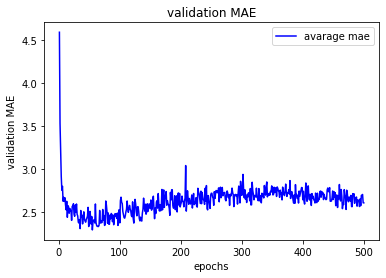

In [7]:
import matplotlib.pyplot as plt

# y軸資料
mae_histories_mean = [
                      np.mean([ mae_history[i_epoch] for mae_history in all_mae_histories]) for i_epoch in range(num_epochs)]
print('mae_histories_mean len = {}'.format(len(mae_histories_mean)))

# x 軸資料 為epochs
epochs = range(1, num_epochs+1)

plt.plot(epochs, mae_histories_mean, 'b', label = 'avarage mae')
plt.title('validation MAE')
plt.xlabel('epochs')
plt.ylabel('validation MAE')
plt.legend()

plt.show()


# 7. 使用EMA (exponential moving average) 平滑處理
# 上面劇烈震盪的曲線

len smooth_points = [4.592369157488983, 4.48616155279745, 4.358612126194604, 4.2141292977545515, 4.067949100629173, 3.9409113597798813, 3.8091996694538635, 3.6952140629984638, 3.5881841065598605, 3.4958021717143124, 3.404397846121669, 3.316307146774369, 3.2470036088425074, 3.1659535525212315, 3.1065304814189956, 3.051702833157458, 2.994974065778422, 2.949414462601205, 2.9059839543103676, 2.8671062682551467, 2.820493173725577, 2.79492823314706, 2.7716561653150182, 2.753940641311642, 2.7258347908064704, 2.6981264789918002, 2.6862764262107746, 2.667303207426132, 2.659740155998388, 2.6409819032214843, 2.6222068270112078, 2.597932833438963, 2.575111113372925, 2.5586145847215374, 2.5332255925104636, 2.531481647286611, 2.5222372979501704, 2.5162171011766836, 2.500592414735897, 2.493246138722414, 2.4939667121346236, 2.4860294359568202, 2.476888935514595, 2.4671460787457304, 2.461503185730355, 2.4582345387842888, 2.4574792260452396, 2.466987987314374, 2.453210057735081, 2.4430139093164454, 2.44

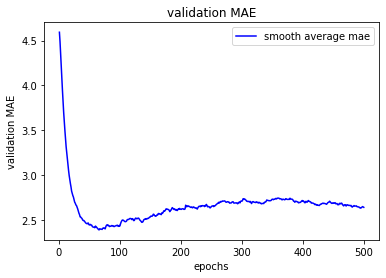

In [34]:
def ema(points, factor):
  smooth_points = []
  for point in points:
    if smooth_points:
      previous = smooth_points[-1]
      smooth_points.append(previous*factor + (1. - factor) * point)
    else:
      smooth_points.append(point)
  print('len smooth_points = {}'.format(smooth_points))
  return smooth_points

# 畫圖
epochs = range(1, num_epochs+1)
smooth_mae = ema(mae_histories_mean, 0.9)

plt.plot(epochs, smooth_mae, 'b', label = 'smooth average mae')
plt.title('validation MAE')
plt.xlabel('epochs')
plt.ylabel('validation MAE')
plt.legend()

plt.show()